# Difference in difference analysis to estimate impact of CICIG on Guatemala's homicide rates

This is a replication of the quantitative analysis made by CrisisGroup in the article ["Saving Guatemala’s Fight Against Crime and Impunity"](https://www.crisisgroup.org/latin-america-caribbean/central-america/guatemala/70-saving-guatemalas-fight-against-crime-and-impunity). The analysis uses synthetics controls estimated with an [entropy balancing method](https://web.stanford.edu/~jhain/Paper/PA2012.pdf) to estimate a counterfactual from nearby latinamerican countries. 



In [124]:
import pandas as pd
import matplotlib as mlp
from matplotlib import pyplot as plt
import numpy as np 
import seaborn as sbs
from statsmodels import api as stm
sbs.set(style="whitegrid")
%matplotlib inline

In [2]:
def tryFunc(functionToTry, onError = np.NaN, showErrors = False):
    def wrapper(inputValue):
        try:
            return functionToTry(inputValue)
        except:
            if showErrors:
                print("Bad value: ", inputValue)
            return onError
    return wrapper

toFloat = lambda x: float(x)

In [3]:
gt1 = pd.read_excel("./guatemala1.xlsx")

In [4]:
gt1.head(3)

,Series Name,Series Code,Country Name,Country Code,YR1990,YR2000,YR2001,YR2002,YR2003,YR2004,...,YR2008,YR2009,YR2010,YR2011,YR2012,YR2013,YR2014,YR2015,YR2016,YR2017
0,homicide,VC.IHR.PSRC.P5,Costa Rica,CRI,..,6.3,6.4,6.3,7.3,6.7,...,11.6,11.7,11.6,10.3,8.7,8.7,10,11.8,..,..
1,homicide,VC.IHR.PSRC.P5,Cuba,CUB,..,..,5.4,5.9,5.7,5.9,...,4.6,5,4.5,4.7,..,..,..,..,..,..
2,homicide,VC.IHR.PSRC.P5,El Salvador,SLV,..,40.3,37.8,37.9,37.2,46.8,...,52.9,72.8,66,72.2,42.7,41.3,64.2,108.6,..,..


In [5]:
gtpop = pd.read_excel("./gtm_pop.xlsx")

In [6]:
gtpop.head(3)

,year,GTM_population,GTM_pop100k
0,2007,13700286,137.00286
1,2008,14006366,140.06366
2,2009,14316208,143.16208


In [209]:
# Ignore Cuba and Haiti
gt1 = gt1[gt1["Country Code"].isin(["CUB", "HTI"]) == False]

In [8]:
gt1.head()

,Series Name,Series Code,Country Name,Country Code,YR1990,YR2000,YR2001,YR2002,YR2003,YR2004,...,YR2008,YR2009,YR2010,YR2011,YR2012,YR2013,YR2014,YR2015,YR2016,YR2017
0,homicide,VC.IHR.PSRC.P5,Costa Rica,CRI,..,6.3,6.4,6.3,7.3,6.7,...,11.6,11.7,11.6,10.3,8.7,8.7,10,11.8,..,..
2,homicide,VC.IHR.PSRC.P5,El Salvador,SLV,..,40.3,37.8,37.9,37.2,46.8,...,52.9,72.8,66,72.2,42.7,41.3,64.2,108.6,..,..
3,homicide,VC.IHR.PSRC.P5,Dominican Republic,DOM,..,14.1,12.6,14.5,21.2,24.6,...,24.8,24.3,25,25.1,22.3,..,17.4,..,..,..
4,homicide,VC.IHR.PSRC.P5,Honduras,HND,..,50.9,54.7,55.7,61.5,53.9,...,61.4,71.5,83.1,93.2,92.7,81.9,74.6,63.8,..,..
5,homicide,VC.IHR.PSRC.P5,Guatemala,GTM,..,24.8,27,29.6,33.7,35,...,44.6,45.1,40.5,37.7,33.5,33.5,31.2,..,..,..


In [9]:
# The available indicators
gt1["Series Name"].value_counts()

CPIA_public_sector                10
under5_mortality_rate             10
homicide                          10
poverty_headcount_320             10
gdp_per_capita_ppp_2011           10
household_consumption             10
CPIA_accountability_corruption    10
youth_literacy_rate               10
adult_literacy_rate               10
Name: Series Name, dtype: int64

In [10]:
cols = gt1.columns[gt1.columns.map(lambda x: x.startswith("YR")) == True]
gt2 = gt1.set_index(["Country Code", "Series Name"])[cols].stack().map(tryFunc(toFloat)).unstack(1).rename(index=lambda x: int(x[2:6]) if str.startswith(x, "YR") else x)

In [11]:
gt2.head().reset_index()

Series Name,Country Code,level_1,CPIA_accountability_corruption,CPIA_public_sector,adult_literacy_rate,gdp_per_capita_ppp_2011,homicide,household_consumption,poverty_headcount_320,under5_mortality_rate,youth_literacy_rate
0,COL,1990,NaN,NaN,NaN,7533.518385,NaN,2894.417281,NaN,35.1,NaN
1,COL,2000,NaN,NaN,NaN,8308.222950,65.7,3101.881202,28.8,25.0,NaN
2,COL,2001,NaN,NaN,NaN,8327.070759,67.9,3105.015716,38.2,24.3,NaN
3,COL,2002,NaN,NaN,NaN,8415.759119,68.3,3122.136969,29.8,23.6,NaN
4,COL,2003,NaN,NaN,NaN,8625.246570,53.4,3170.331340,27.7,22.9,NaN


In [12]:
# This gives the same that stata
del gt2["CPIA_accountability_corruption"]
del gt2["CPIA_public_sector"]
gt2[gt2.index.get_level_values(1) < 2007].describe()

Series Name,adult_literacy_rate,gdp_per_capita_ppp_2011,homicide,household_consumption,poverty_headcount_320,under5_mortality_rate,youth_literacy_rate
count,20.000000,80.000000,69.000000,79.000000,56.000000,80.00000,20.000000
mean,87.666931,8599.024509,28.108696,3245.349387,24.321429,30.63875,94.577347
std,6.772482,3851.423356,19.192383,1502.428044,10.644806,13.38700,4.636641
min,69.101730,3003.519024,6.300000,1102.633868,9.900000,10.30000,82.220260
25%,86.137218,6070.409423,10.400000,2175.455903,16.525000,22.07500,94.767635
50%,90.405135,8238.534249,24.800000,3105.015716,23.150000,27.80000,96.346065
75%,91.999635,11090.964672,43.600000,4265.429084,28.500000,37.32500,97.619985
max,94.868190,16149.480338,68.300000,6815.420781,64.300000,81.80000,97.991310


In [13]:
cols = ["gdp_per_capita_ppp_2011", "homicide", "household_consumption", "poverty_headcount_320"]
gt2["intercept"] = 1
def trends(df):
    results = []
    for col in cols:
        results.append(np.linalg.lstsq(df[df[col].isna() == False].reset_index()[["intercept", "level_1"]], df[df[col].isna() == False][col])[0][1])
    return pd.Series(index = cols, data = results)
trends = gt2[(gt2.index.get_level_values(1) < 2007 )].groupby("Country Code").apply(trends)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


In [14]:
# The trends for each country for each indicator
# This is showing the same results as the original file.
trends

,gdp_per_capita_ppp_2011,homicide,household_consumption,poverty_headcount_320
Country Code,,,,
COL,121.033285,-5.971429,31.783762,-1.597143
CRI,225.242755,0.314286,72.978773,-0.589339
DOM,239.545720,2.253571,83.524545,0.753571
GTM,80.325020,3.101429,34.219756,0.216667
HND,36.268825,-1.321429,14.579777,-1.480016
MEX,178.282345,-0.207143,116.731212,-2.510000
NIC,50.276370,0.671429,19.355949,-2.625000
PAN,272.126317,0.100000,105.051787,-0.796429
SLV,161.672645,4.885714,83.784653,-0.903571


In [15]:
trends.columns = trends.columns.map(lambda x: "trend_" + x)

In [16]:
trends = pd.concat([trends, gt2[gt2.index.get_level_values(1) < 2007].groupby(level=[0]).mean()], axis = 1)

In [17]:
trends.to_csv("trends.csv")

In [18]:
gt2.to_csv("data_time_series.csv")

Since the entropy balancing method is not available for python, I'll have to defer the synthetic control estimation to R, where the package "ebal", from the same author will be used to estimate the synth control weights.

# Comparing Guatemala with the Synthetic Control

Now reading the weights generated by ebalance package in R and the weights generated by Stata (the same CrisisGroup used)


In [19]:
ebal_st = pd.read_csv("./ebalanced_stata.csv", index_col=0)
ebal_st.loc["GTM"] = 1
ebal_st.columns = ["ebal_st"]
ebal_R = pd.read_csv("./ebalanced.csv", index_col=0)
ebal_R.loc["GTM"] = 1
ebal_R.columns = ["ebal_R"]

In [61]:
gt3 = gt2.reset_index()
gt3 = gt2.merge(ebal_st, left_on="Country Code", right_index=True).reset_index()
gt3 = gt3.merge(ebal_R, left_on="level_0", right_index=True)
gt3["logHom"] = np.log10(gt3.homicide)
gt3["Treatment"] = gt3.level_0 == "GTM"

In [65]:
def wmean(df, m, w):
    return df[m].multiply(df[w]).sum() / \
                df[w][df[m].notna()].sum()

# TEST
# wmean(gt3[gt3.level_0 == "GTM"], "homicide", "ebal_st" ), gt3[gt3.level_0 == "GTM"].homicide.mean()


In [286]:
avgCols = ['logHom','adult_literacy_rate', 'gdp_per_capita_ppp_2011', 'homicide',
        'household_consumption', 'poverty_headcount_320',
        'under5_mortality_rate', 'youth_literacy_rate']
gt4_st = gt3.groupby(["Treatment", "level_1"]).apply(
    lambda x: pd.Series([ wmean(x, col, "ebal_st") for col in avgCols ], avgCols) )
gt4_R  = gt3.groupby(["Treatment", "level_1"]).apply(
    lambda x: pd.Series([ wmean(x, col, "ebal_R") for col in avgCols ], avgCols) )
gt4_unw  = gt3.groupby(["Treatment", "level_1"]).apply(
    lambda x: pd.Series([ x[col].mean() for col in avgCols ], avgCols) )

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


# Unweighted means (no entropy balancing & synth control)

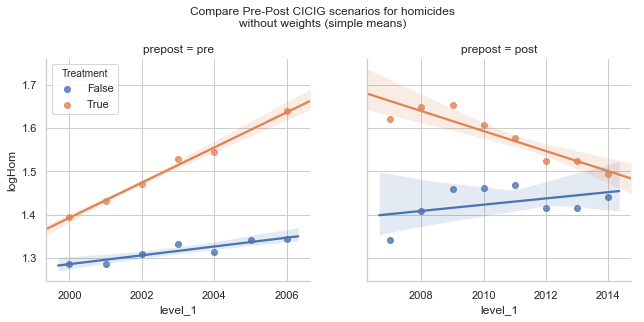

In [287]:
gt4_unw["prepost"] = gt4_unw.index.get_level_values(1).map(lambda x: ("pre" if x<2007 else "post"), 1)
sbs.lmplot("level_1", "logHom", gt4_unw[gt4_unw.index.get_level_values(1).isin(list(range(2000, 2015)))]\
               .reset_index(), "Treatment", col = "prepost", sharex=False, legend_out=False)
# Finally, getting the same graph that CrisisGroup obtained in stata, of course, using their ebalance results.
plt.suptitle("Compare Pre-Post CICIG scenarios for homicides\nwithout weights (simple means)")
plt.tight_layout(4.5)

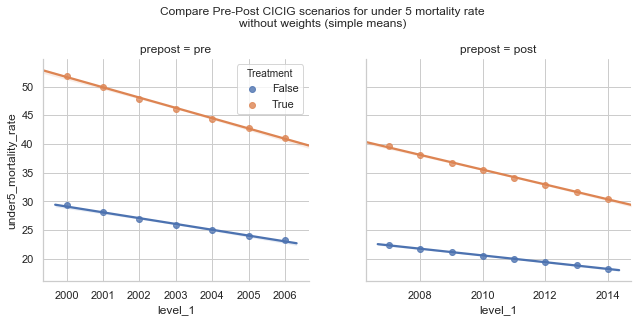

In [288]:
axs = sbs.lmplot("level_1", "under5_mortality_rate", gt4_unw[gt4_unw.index.get_level_values(1).isin(list(range(2000, 2015)))]\
               .reset_index(), "Treatment", col = "prepost", sharex=False, legend_out=False)
plt.suptitle("Compare Pre-Post CICIG scenarios for under 5 mortality rate\nwithout weights (simple means)")
plt.tight_layout(4.5)

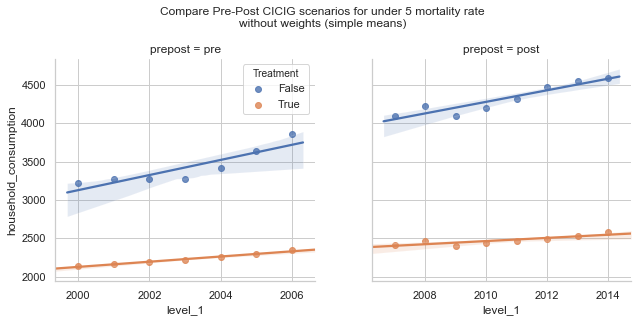

In [289]:
axs = sbs.lmplot("level_1", "household_consumption", gt4_unw[gt4_unw.index.get_level_values(1).isin(list(range(2000, 2015)))]\
               .reset_index(), "Treatment", col = "prepost", sharex=False, legend_out=False)
plt.suptitle("Compare Pre-Post CICIG scenarios for under 5 mortality rate\nwithout weights (simple means)")
plt.tight_layout(4.5)

# Using weights estimated with Stata ebalance package

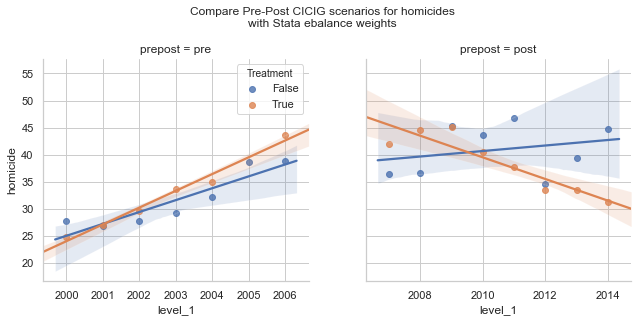

In [121]:
gt4_st["prepost"] = gt4_st.index.get_level_values(1).map(lambda x: ("pre" if x<2007 else "post"), 1)
sbs.lmplot("level_1", "homicide", gt4_st[gt4_st.index.get_level_values(1).isin(list(range(2000, 2015)))]\
               .reset_index(), "Treatment", col = "prepost", sharex=False, legend_out=False)
# Finally, getting the same graph that CrisisGroup obtained in stata, of course, using their ebalance results.
plt.suptitle("Compare Pre-Post CICIG scenarios for homicides\nwith Stata ebalance weights")
plt.tight_layout(4.5)

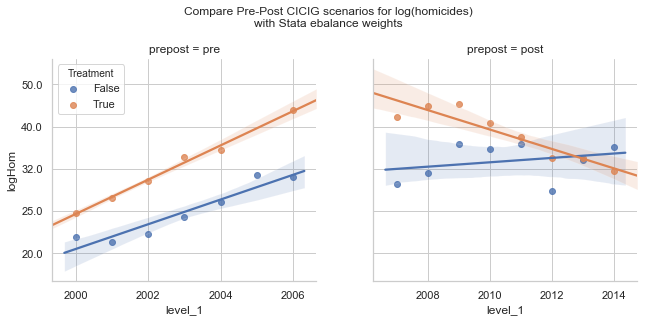

In [275]:
axs = sbs.lmplot("level_1", "logHom", gt4_st[gt4_st.index.get_level_values(1).isin(list(range(2000, 2015)))]\
               .reset_index(), "Treatment", col = "prepost", sharex=False, legend_out=False)
plt.suptitle("Compare Pre-Post CICIG scenarios for log(homicides)\nwith Stata ebalance weights")
plt.tight_layout(4.5)
axs.set_yticklabels(np.power(10, axs.axes[0,0].get_yticks()).round())

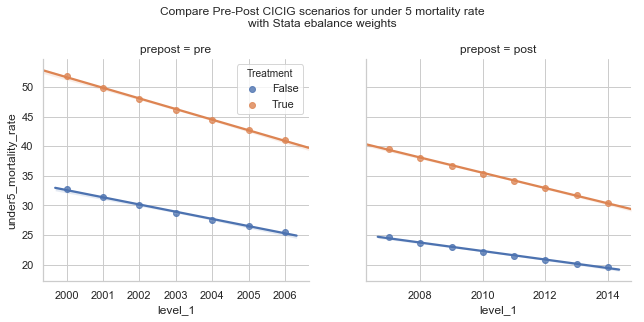

In [274]:
axs = sbs.lmplot("level_1", "under5_mortality_rate", gt4_st[gt4_st.index.get_level_values(1).isin(list(range(2000, 2015)))]\
               .reset_index(), "Treatment", col = "prepost", sharex=False, legend_out=False)
plt.suptitle("Compare Pre-Post CICIG scenarios for under 5 mortality rate\nwith Stata ebalance weights")
plt.tight_layout(4.5)

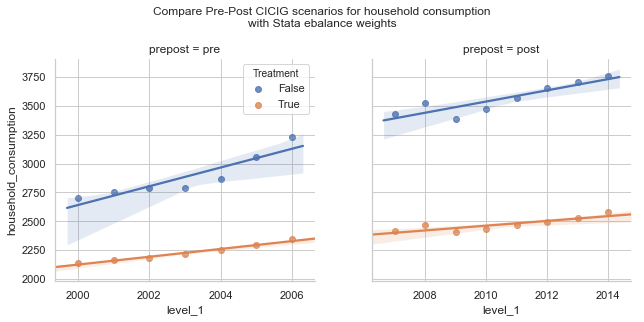

In [273]:
axs = sbs.lmplot("level_1", "household_consumption", gt4_st[gt4_st.index.get_level_values(1).isin(list(range(2000, 2015)))]\
               .reset_index(), "Treatment", col = "prepost", sharex=False, legend_out=False)
plt.suptitle("Compare Pre-Post CICIG scenarios for household consumption\nwith Stata ebalance weights")
plt.tight_layout(4.5)

# Using weights estimated with R ebal

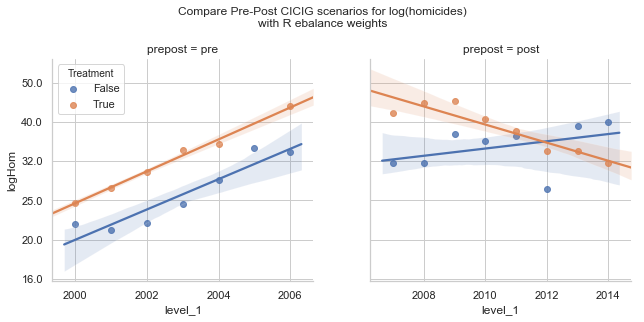

In [272]:
gt4_R["prepost"] = gt4_R.index.get_level_values(1).map(lambda x: ("pre" if x<2007 else "post"), 1)
axs = sbs.lmplot("level_1", "logHom", gt4_R[gt4_R.index.get_level_values(1).isin(list(range(2000, 2015)))]\
               .reset_index(), "Treatment", col = "prepost", sharex=False, legend_out=False)
axs.set_yticklabels(np.power(10, axs.axes[0,0].get_yticks()).round())

plt.suptitle("Compare Pre-Post CICIG scenarios for log(homicides)\nwith R ebalance weights")
plt.tight_layout(4.5)


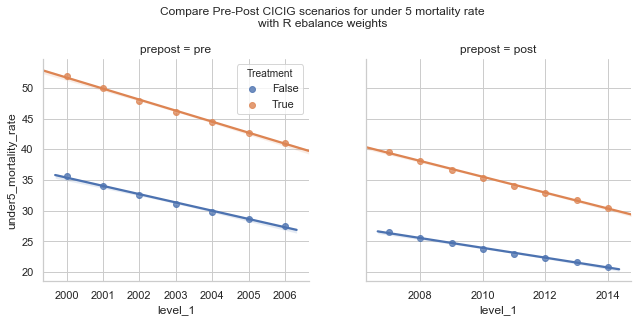

In [269]:
axs = sbs.lmplot("level_1", "under5_mortality_rate", gt4_R[gt4_R.index.get_level_values(1).isin(list(range(2000, 2015)))]\
               .reset_index(), "Treatment", col = "prepost", sharex=False, legend_out=False)
plt.suptitle("Compare Pre-Post CICIG scenarios for under 5 mortality rate\nwith R ebalance weights")
plt.tight_layout(4.5)

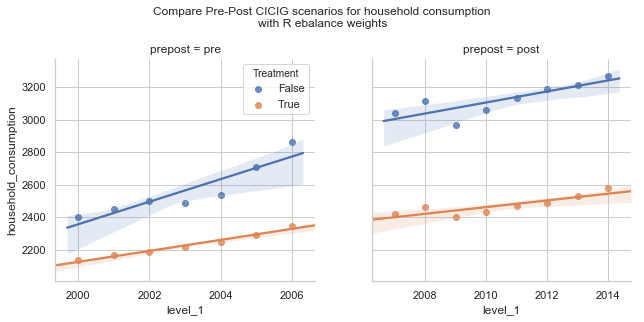

In [268]:
axs = sbs.lmplot("level_1", "household_consumption", gt4_R[gt4_R.index.get_level_values(1).isin(list(range(2000, 2015)))]\
               .reset_index(), "Treatment", col = "prepost", sharex=False, legend_out=False)
plt.suptitle("Compare Pre-Post CICIG scenarios for household consumption\nwith R ebalance weights")
plt.tight_layout(4.5)

# Estimation of impact with a simple regression

In [237]:
gt4_R["Tx"] = gt4_R.index.get_level_values(0).astype(int)
gt4_R["After"] = (gt4_R["prepost"] == "post").astype(int)
reg = stm.GLM.from_formula("homicide ~ After + Tx*After - Tx+ C(level_1)", gt4_R[gt4_R.index.get_level_values(1).isin(list(range(2000, 2015)))].reset_index())
fit = reg.fit()
print(fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               homicide   No. Observations:                   29
Model:                            GLM   Df Residuals:                       13
Model Family:                Gaussian   Df Model:                           15
Link Function:               identity   Scale:                          19.182
Method:                          IRLS   Log-Likelihood:                -72.348
Date:                Mon, 21 Jan 2019   Deviance:                       249.37
Time:                        12:23:26   Pearson chi2:                     249.
No. Iterations:                     3   Covariance Type:             nonrobust
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             25.7750      3.097      8.323      0.000      19.705      31.845
C(level_1)[T.2001]     0.480

In [238]:
print("Net avoided homicides (using R ebalance and Python GLM)")
ci = fit.conf_int().loc["Tx:After"]
print((gtpop.GTM_pop100k * fit.params["Tx:After"]).sum().round(), "(C.I. 95% ", (gtpop.GTM_pop100k * ci[0]).sum().round(), 
      ", ", (gtpop.GTM_pop100k * ci[1]).sum().round() ," )")


Net avoided homicides (using R ebalance and Python GLM)
-5068.0 (C.I. 95%  -12285.0 ,  2149.0  )


In [240]:
gt4_st["Tx"] = gt4_st.index.get_level_values(0).astype(int)
gt4_st["After"] = (gt4_st["prepost"] == "post").astype(int)
reg = stm.GLM.from_formula("homicide ~ After + Tx*After - Tx + C(level_1)", gt4_st[gt4_R.index.get_level_values(1).isin(list(range(2000, 2015)))].reset_index())
fit = reg.fit()
print(fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               homicide   No. Observations:                   29
Model:                            GLM   Df Residuals:                       13
Model Family:                Gaussian   Df Model:                           15
Link Function:               identity   Scale:                          16.159
Method:                          IRLS   Log-Likelihood:                -69.861
Date:                Mon, 21 Jan 2019   Deviance:                       210.06
Time:                        12:23:46   Pearson chi2:                     210.
No. Iterations:                     3   Covariance Type:             nonrobust
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             26.2348      2.842      9.230      0.000      20.664      31.806
C(level_1)[T.2001]     0.717

In [241]:
print("Net avoided homicides (using Stata ebalance and Python GLM)")
ci = fit.conf_int().loc["Tx:After"]
print((gtpop.GTM_pop100k * fit.params["Tx:After"]).sum().round(), "(C.I. 95% ", (gtpop.GTM_pop100k * ci[0]).sum().round(), 
      ", ", (gtpop.GTM_pop100k * ci[1]).sum().round() ," )")

# Crisis Group result in using stata GLM with robust variance is  4658 

Net avoided homicides (using Stata ebalance and Python GLM)
-4077.0 (C.I. 95%  -10700.0 ,  2547.0  )


In [249]:
# Comparing under 5 mort. rate. Compare model with different intercepts and with same ints.
reg = stm.GLM.from_formula("under5_mortality_rate ~ After + Tx*After - Tx + C(level_1)", gt4_st[gt4_R.index.get_level_values(1).isin(list(range(2000, 2015)))].reset_index())
fit = reg.fit()
print(fit.summary())

                   Generalized Linear Model Regression Results                   
Dep. Variable:     under5_mortality_rate   No. Observations:                   30
Model:                               GLM   Df Residuals:                       14
Model Family:                   Gaussian   Df Model:                           15
Link Function:                  identity   Scale:                          75.997
Method:                             IRLS   Log-Likelihood:                -96.097
Date:                   Mon, 21 Jan 2019   Deviance:                       1064.0
Time:                           12:29:21   Pearson chi2:                 1.06e+03
No. Iterations:                        3   Covariance Type:             nonrobust
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             42.3676      6.164      6.873      0.000      30.286      54.449
C

In [248]:
reg = stm.GLM.from_formula("under5_mortality_rate ~ After + Tx*After + C(level_1)", gt4_st[gt4_R.index.get_level_values(1).isin(list(range(2000, 2015)))].reset_index())
fit = reg.fit()
print(fit.summary())

                   Generalized Linear Model Regression Results                   
Dep. Variable:     under5_mortality_rate   No. Observations:                   30
Model:                               GLM   Df Residuals:                       13
Model Family:                   Gaussian   Df Model:                           16
Link Function:                  identity   Scale:                         0.88926
Method:                             IRLS   Log-Likelihood:                -28.264
Date:                   Mon, 21 Jan 2019   Deviance:                       11.560
Time:                           12:28:23   Pearson chi2:                     11.6
No. Iterations:                        3   Covariance Type:             nonrobust
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             33.6975      0.713     47.272      0.000      32.300      35.095
C

In [252]:
# Estimation of impact over homicides using different intercepts
reg = stm.GLM.from_formula("homicide ~ After + Tx*After + C(level_1)", gt4_st[gt4_R.index.get_level_values(1).isin(list(range(2000, 2015)))].reset_index())
fit = reg.fit()
print(fit.summary())
print("Net avoided homicides (using Stata ebalance and Python GLM with different intercepts)")
ci = fit.conf_int().loc["Tx:After"]
print((gtpop.GTM_pop100k * fit.params["Tx:After"]).sum().round(), "(C.I. 95% ", (gtpop.GTM_pop100k * ci[0]).sum().round(), 
      ", ", (gtpop.GTM_pop100k * ci[1]).sum().round() ," )")

                 Generalized Linear Model Regression Results                  
Dep. Variable:               homicide   No. Observations:                   29
Model:                            GLM   Df Residuals:                       12
Model Family:                Gaussian   Df Model:                           16
Link Function:               identity   Scale:                          16.653
Method:                          IRLS   Log-Likelihood:                -69.137
Date:                Mon, 21 Jan 2019   Deviance:                       199.84
Time:                        12:30:57   Pearson chi2:                     200.
No. Iterations:                     3   Covariance Type:             nonrobust
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             25.3119      3.117      8.121      0.000      19.203      31.421
C(level_1)[T.2001]     0.717

In [278]:
# Estimation of impact with the simplest DID possible:
a = gt4_st.groupby(["Tx", "After"]).homicide.mean()
print(a.unstack(1))
did = (a[0][0] - a[1][0]) - (a[0][1] - a[1][1])
print("Simplest DID ", (gtpop.GTM_pop100k * did).sum())

After          0         1
Tx                        
0      31.598530  44.76209
1      32.283333  38.50000
Simplest DID  -11680.606493116184


# Conclusion

I have obtained a similar result to the one CrisisGroup obtained. DID results are not significant, and confidence intervals are very large even though they suggest an effect may be present. This can be due to the very small sample size used to estimate the weights (few years, covariates and countries to estimate the weights)

I think covariates are not very good and I want to attempt to do a similar analysis using microsynth package and other covariates. That package uses time series instead of just the means (in this analysis only mean moments are used to fit ebalance weights). Despite this, if you look at the graphs for **under 5 mortality rate** and **household consumption**, the trends are quite comparable and so, the parallel trends assumption of the diff&diff methodology is satisfied. I am not sure whether or not the GLM regression is correct. I think the synthetic control and treatment group should be allowed to have different intercepts. By looking at the graph of homicides it is evident that both groups have different intercepts. DID models usually include a term to account for such difference. I have also included the same graphics with unweighted data (no synth control) to show how the entropy balancing is succesfully generating a homicide synthetic control with almost parallel trends.


Beyond the statistical analysis and its many shortcomings, it is a very well known fact that homicide rate in Guatemala has been declining in the last years. Attributing that only to CICIG would be a big mistake, however I do believe corruption and organized crime in Guatemala are related and therefore I am biased to think that the fight against corruption has had an impact on this. Unfortunately, now that CICIG is officially gone, many corruption cases are falling apart and we will be able to see the effect of CICIG abscence with actual human lifes, instead of a synthetic counterfactual.